In [587]:
import pandas as pd

df = pd.read_csv('data.csv')

In [588]:
# Remove the Timestamp column
df = df.drop(columns=['Timestamp'])

In [589]:
# Rename the columns
df = df.rename(columns={
    "Thank you for your participation. If you want to receive the survey results, enter your email address here. We won't share your email address with anyone, nor send you any ads.": 'email',
    "What's your age?": 'age',
    "What's your gender?": 'gender',
    "Where do you live?": 'homeland',
    "Where do you usually enjoy your holidays? Select all that apply.": 'target',
    "When on vacation, where do you usually stay? Select all that apply.": 'accommodation',
    "Who do you usually enjoy your holidays with? Select all that apply.": 'company',
    "What activities best describe your typical summer vacation? Select all that apply.": 'activities',
    "How do you choose where to go on vacation? Select all that apply.": 'decision',
    "What means of transport do you normally take when going on vacation? Select all that apply.": 'transport',
    "How much did you spend in total during your last summer holidays? Use this format: <cost> <currency> (e.g. 350 €)": 'cost',
    "How much did you enjoy your last summer vacation?": 'enjoyment',
    "Thank you for your participation. If you want to receive the survey results, enter your email address here. We won't share your email address with anyone, nor send you any ads.": 'email',
})

In [590]:
# Extract the email column into a separate array
emails = df['email'].values
# Remove the email column from the dataframe
df = df.drop(columns=['email'])

In [591]:
# Change all the gender values that aren't 'Male' or 'Female' into 'Other'
df['gender'] = df['gender'].apply(lambda x: 'Other' if x != 'Male' and x != 'Female' else x)

# Plot the gender distribution
import matplotlib.pyplot as plt

genders = df.groupby('gender')['gender'].count()
genders

gender
Female    156
Male      167
Other      16
Name: gender, dtype: int64

In [592]:
# Parse the raw cost values and convert to euros

import re
from typing import List, Tuple


# ( [symbols], change to eur )
currency_table: Tuple[List[str], float] = (
    (['€', 'eur', 'euro', 'euros'], 1.00),
    (['$', 'usd', 'dollar', 'dollars'], 1.00),
    (['£', 'gbp', 'pound', 'pounds'], 1.15),
    (['cad'], 0.76),
    (['aud'], 0.67),
    (['chf'], 1.04),
    (['jpy', 'yen', 'yens', '¥', '円'], 0.0069),
    (['inr', '₹'], 0.013),
    (['php', '₱'], 0.018),
    (['sek'], 0.096),
    (['rmb', '¥', '元', 'renminbi'], 0.14),
    (['dkk'], 0.13),
    (['zar'], 0.057),
    (('pen', 'sol'), 0.26),
)


def assume_eur_if_no_symbol(cost: str):
    try:
        cost = cost.replace(',', '').replace('+', '')
        return float(cost)
    except ValueError:
        return None


def find_number(string) -> int | None:
    numbers = re.findall(r'\d+', string)

    if len(numbers) == 0:
        return None

    return max([int(x) for x in numbers])


def parse_cost(cost: str) -> int | None:
    cost = str(cost).lower()

    if cost == 'nan':
        return None

    assume_eur = assume_eur_if_no_symbol(cost)
    if assume_eur is not None:
        return assume_eur

    for symbols, change in currency_table:
        for symbol in symbols:
            if symbol in cost:
                number = find_number(cost)
                if number is None:
                    return None
                return number * change
    
    print(f'Unknown currency: {cost}')
    return None


def parse_and_normalize(cost: str) -> int | None:
    cost = str(cost)
    cost = parse_cost(cost)
    if cost is None:
        return None

    if cost > 10000:
        return 10000
    return cost


df['cost'] = df['cost'].apply(parse_and_normalize)


Unknown currency: i don't know
Unknown currency: 🖕
Unknown currency: boh
Unknown currency: rp 500.000 idr
Unknown currency: not sure, my parents paid
Unknown currency: i split the cost and with all the buying and stuff i don’t have an exact number lol
Unknown currency: unknown 
Unknown currency: 6000 ntd/twd
Unknown currency: 400e
Unknown currency: idk
Unknown currency: idk
Unknown currency: don't know
Unknown currency: 18000kr? not sure
Unknown currency: not much but i travel dirty
Unknown currency: i don't know 
Unknown currency: 0 (my parents paid for everything)
Unknown currency: i forget
Unknown currency: maybe 500 hrk
Unknown currency: not sure
Unknown currency: i don’t know 


In [593]:
# Normalize the homeland column

def parse_homeland(string) -> str:
    string = str(string).lower()

    europe_substrings = ['europe', 'italia', 'milano', 'israel']
    if any(sub in string for sub in europe_substrings):
        return 'europe'

    north_america_substrings = ['america', 'usa', 'canada']
    if 'south' not in string and any([sub in string for sub in north_america_substrings]):
        return 'north america'
    
    asia_substrings = ['japan', 'china', 'asia', 'india', 'korea', 'singapore', 'thailand', 'vietnam', 'new zealand']
    if any([sub in string for sub in asia_substrings]):
        return 'asia'
    
    normal_countries = ['australia', 'south america', 'africa']
    if any([sub in string for sub in normal_countries]):
        return string

    # Log other homelands
    print(string)

    return string
    

df['homeland'] = df['homeland'].apply(parse_homeland)



In [594]:
# Parse the accomodation column

def parse_accomodation_name(accomodation) -> str:
    
    normal_accomodations = [
        'hotel or motel',
        'rent a house',
        'family or friend\'s house',
        'camper',
        'tent or hut'
    ]

    if any([x in accomodation for x in normal_accomodations]):
        return accomodation

    if 'rent' in accomodation:
        return 'rent a house'
    
    if 'house' in accomodation:
        return 'family or friend\'s house'

    hotel_substrings = ['hotel', 'motel', 'resort']
    if any([x in accomodation for x in hotel_substrings]):
        return 'hotel or motel'
    
    if accomodation == 'caravan':
        return 'camper'
    
    if 'hostel' in accomodation:
        return 'hostel'

    # Log other accomodations
    print(accomodation)
    
    return accomodation


def parse_accomodations(accomodations) -> str:
    accomodations = str(accomodations).lower()
    accomodations = accomodations.split(';')
    accomodations = [parse_accomodation_name(x) for x in accomodations]
    return ';'.join(accomodations)


df['accommodation'] = df['accommodation'].apply(parse_accomodations)

n/a i live near vegas so no sleeping there
cabin
airbnb/vrbo
sommarstuga
boat
airbnb
airbnb
airb&b
vehicle 
village 
air bnb
condo
cottage 
nan
condo
cruise ship 
holiday inn


In [595]:
# Parse target column

normal_targets = [
    'seaside',
    'mountains',
    'lake or river',
    'countryside'
]


def parse_target_name(target) -> str:

    if any([x in target for x in normal_targets]):
        return target
    
    city_substrings = ['city', 'town', 'village', 'cities', 'home', 'urban']
    if any([x in target for x in city_substrings]):
        return 'city'
    
    shooting_substrings = ['shooting', 'hunt', 'hunting', 'battle']
    if any([x in target for x in shooting_substrings]):
        return 'shooting range'

    print(target)

    return target


def parse_targets(targets) -> str:
    targets = str(targets).lower()
    targets = targets.split(';')
    targets = [parse_target_name(x) for x in targets]
    return ';'.join(targets)


df['target'] = df['target'].apply(parse_targets)

always in the same state i live 
cultural and historical places as well
visiting family
at my family's house in taiwan
wooded parks
urban
forest
i don't really do holidays
 i've been unabole to work for a long time and while i could afford to travel, my anxiety usually prevents me from doing more than the occasional day trip
desert or national park
inland


In [596]:
# Parse company column

def parse_company_name(company) -> str:

    normal_companies = [
        'family',
        'friends',
        'boyfriend/girlfriend',
        'alone'
    ]

    if company == 'boyfriend/girlfriend' or 'partner' in company:
        return 'partner'

    if any([x in company for x in normal_companies]):
        return company

    print(company)

    return company


def parse_companies(companies) -> str:
    companies = str(companies).lower()
    companies = companies.split(';')
    companies = [parse_company_name(x) for x in companies]
    return ';'.join(companies)


df['company'] = df['company'].apply(parse_companies)

In [597]:
# Parse the transport column

def parse_transport_name(transport) -> str:

    normal_transports = [
        'car',
        'train',
        'airplane',
        'bus or taxi'
    ]

    if any([x in transport for x in normal_transports]):
        return transport
    
    if 'subway' in transport:
        return 'train'

    if 'plane' in transport:
        return 'airplane'
    
    bus_substrings = ['bus', 'taxi', 'uber', 'coach']
    if any([x in transport for x in bus_substrings]):
        return 'bus or taxi'
    
    boat_substrings = ['boat', 'ship', 'ferry']
    if any([x in transport for x in boat_substrings]):
        return 'boat'

    print(transport)

    return transport


def parse_transport(transports) -> str:
    transports = str(transports).lower()
    transports = transports.split(';')
    transports = [parse_transport_name(x) for x in transports]
    return ';'.join(transports)


df['transport'] = df['transport'].apply(parse_transport)

bycicle


In [598]:
# Parse the age column into ranges

def parse_age(age) -> str:
    
    if age == 'Less than 14 years old':
        return '<14'
    if age == '14 - 16 years old':
        return '14-16'
    if age == '16 - 18 years old':
        return '16-18'
    if age == '18 - 25 years old':
        return '18-25'
    if age == 'More than 25 years old':
        return '>25'
    

df['age'] = df['age'].apply(parse_age)

df['age'].value_counts()



>25      152
18-25    127
16-18     33
14-16     26
<14        1
Name: age, dtype: int64

In [599]:
# Parse the activities

def parse_activity_name(activity) -> str:

    normal_activities = [
        'going to the beach',
        'trekking or walking',
        'visiting museums and cultural sites',
        'extreme sports',
        'working',
        'travelling, visiting cities and places of interest',
        'staying at home',
        'cruise',
        'camping',
        'attending concerts or live events (e.g. football match)'
    ]

    if any([x in activity for x in normal_activities]):
        return activity
    
    events_substrings = ['concert', 'match', 'event', 'party', 'club']
    if any([x in activity for x in events_substrings]):
        return 'attending concerts or live events (e.g. football match)'
    
    beach_substrings = ['swimming', 'sunbathing', 'playing in the sand']
    if any([x in activity for x in beach_substrings]):
        return 'going to the beach'

    trekking_substrings = ['trekking', 'walking', 'hiking', 'mountain']
    if any([x in activity for x in trekking_substrings]):
        return 'trekking or walking'

    visiting_substrings = ['visiting', 'tour', 'sightseeing', 'bar', 'shop']
    if any([x in activity for x in visiting_substrings]):
        return 'visiting museums and cultural sites'
    
    sailing_substrings = ['sail', 'yacht', 'boat', 'surf', 'canoe', 'kayak']
    if any([x in activity for x in sailing_substrings]):
        return 'sailing'

    relaxing_substrings = ['relax', 'chill', 'rest', 'sleep', 'read', 'nature', 'fish']
    if any([x in activity for x in relaxing_substrings]):
        return 'relaxing'
    
    shooting_substrings = ['shooting', 'hunt', 'hunting', 'battle', 'arch']
    if any([x in activity for x in shooting_substrings]):
        return 'shooting'

    travelling_substrings = ['zoo', 'cuisine']
    if any([x in activity for x in travelling_substrings]):
        return 'travelling, visiting cities and places of interest'
    
    working_substrings = ['work', 'job', 'office', 'school', 'university', 'studio', 'study']
    if any([x in activity for x in working_substrings]):
        return 'working'

    print(activity)

    return activity


def parse_activities(activities) -> str:
    activities = str(activities).lower()

    activities = map(lambda x: x.strip(), activities.split(';'))

    activities = map(lambda x: parse_activity_name(x), activities)

    return ';'.join(activities)


df['activities'] = df['activities'].apply(parse_activities)



nan
n/a (only been on vacation in my childhood)


In [600]:
# Parse the deicsion column

def parse_decision_name(decision) -> str:

    normal_decisions = [
        'i have friends there',
        'my relatives live there',
        'i want to visit a certain place',
        'i always go there on vacation, it\'s a tradition',
        'i have a house there'
    ]

    if any([x in decision for x in normal_decisions]):
        return decision

    want_substrings = ['nice', 'agree', 'group', 'partner', 'plan', 'interesting', 'good', 'research', 'weather', 'climate']
    if any([x in decision for x in want_substrings]):
        return 'i want to visit a certain place'
    
    near_substrings = ['near', 'close', 'close to', 'far', 'nice', 'distance', 'cheap', 'price', 'avail', 'afford', 'budget']
    if any([x in decision for x in near_substrings]):
        return 'near and cheap'
    
    parents_substrings = ['parent', 'someone else', 'decides', 'chooses', 'takes me', 'am not', 'wants']
    if any([x in decision for x in parents_substrings]):
        return 'someone else decides'

    print(decision)

    return decision


def parse_decisions(decisions) -> str:
    decisions = str(decisions).lower()

    decisions = map(lambda x: x.strip(), decisions.split(';'))

    decisions = map(lambda x: parse_decision_name(x), decisions)

    return ';'.join(decisions)
    

df['decision'] = df['decision'].apply(parse_decisions)


people’s recommendations
sometims i visit my sister for a few days who lives in a different city, but i don#t really view it as a vacation


age
<14              NaN
14-16    1260.833333
16-18    1509.441176
18-25    1126.820988
>25      1591.382353
Name: cost, dtype: float64


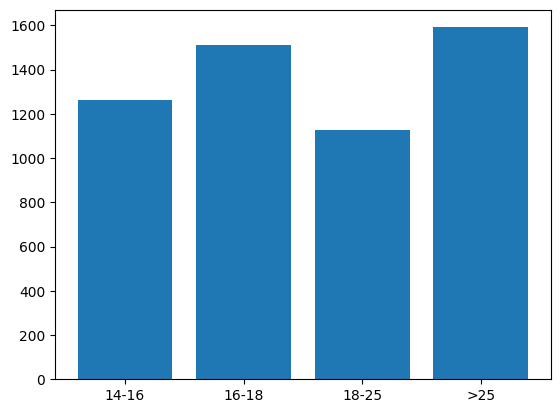

In [601]:
# Calculate average cost for each age range

# people after 18 stop getting money from their parents, so they have a smaller budget
# people 14-16 have a smaller budget because they are still too young to do much on their own
# people 16-18 have the highest budget because they are quite independent and their parents pay for them

costs = df.groupby('age')['cost'].mean()

# Reorder the costs so that the age ranges are in the correct order
costs = costs.reindex(['<14', '14-16', '16-18', '18-25', '>25'])

# Plot the average cost for each age range
import matplotlib.pyplot as plt

print(costs)

plt.bar(costs.index, costs.values)
plt.show()


asia: 2782.50 (8 people)
north america: 1587.40 (130 people)
south america: 1193.33 (6 people)
europe: 1120.63 (94 people)
australia: 889.93 (7 people)


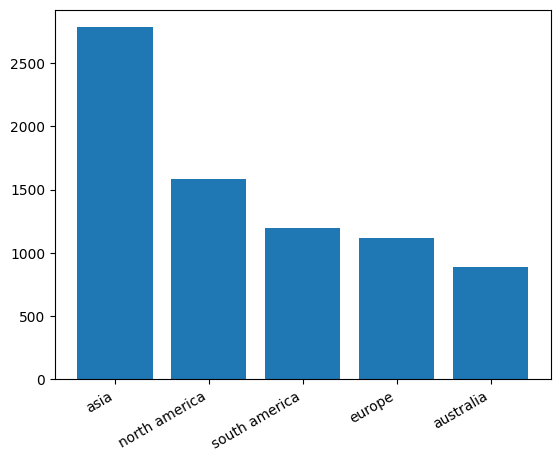

In [602]:
# Average cost for each homeland

cost_per_land = df.groupby('homeland')['cost'].mean()
people_per_land = df.groupby('homeland')['cost'].count()

# Remove africa because it has too few people
cost_per_land = cost_per_land.drop('africa')

# Sort from highest to lowest
cost_per_land = cost_per_land.sort_values(ascending=False)

import matplotlib.pyplot as plt

# Print cost per land and number of people per land on the same line
for land, cost in cost_per_land.items():
    print(f'{land}: {cost:.2f} ({people_per_land[land]} people)')
    

plt.bar(cost_per_land.index, cost_per_land.values)
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


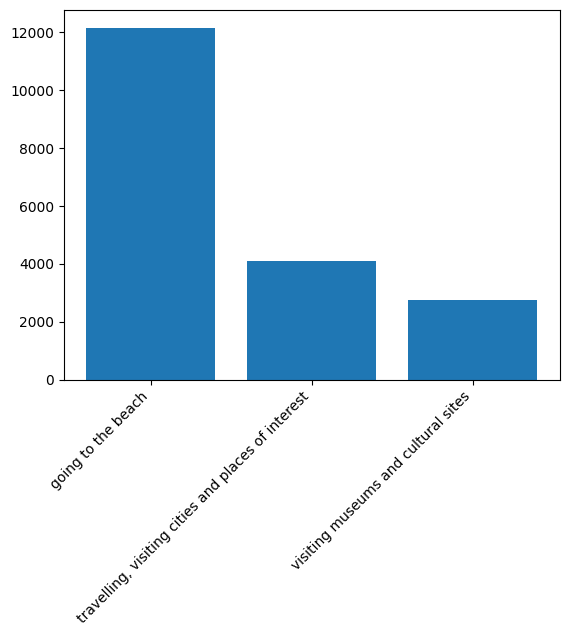

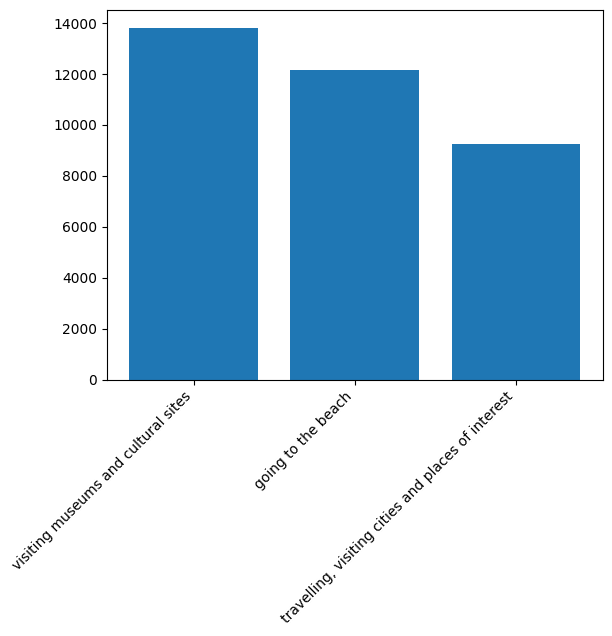

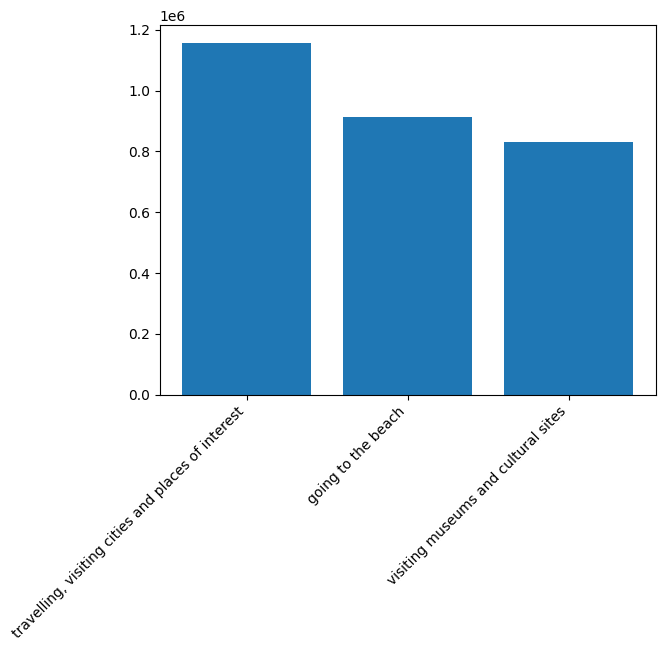

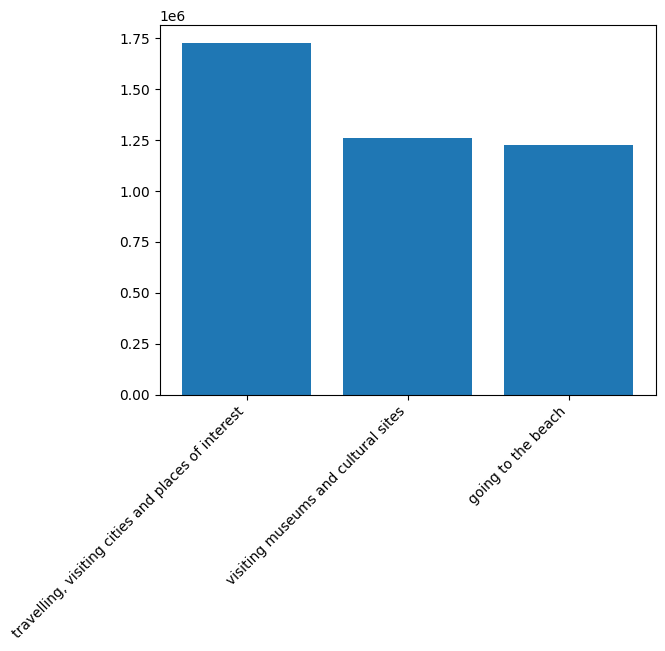

,going to the beach,"travelling, visiting cities and places of interest",visiting museums and cultural sites,trekking or walking,staying at home,attending concerts or live events (e.g. football match),extreme sports,camping,working,cruise,sailing,relaxing,shooting,n/a (only been on vacation in my childhood),nan
age,,,,,,,,,,,,,,,
14-16,23.0,16.0,14.0,9.0,8.0,5.0,3.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
16-18,23.0,21.0,24.0,10.0,14.0,9.0,2.0,2.0,5.0,8.0,1.0,1.0,0.0,0.0,0.0
18-25,97.0,105.0,94.0,77.0,60.0,25.0,4.0,31.0,6.0,2.0,2.0,1.0,2.0,1.0,0.0
>25,107.0,120.0,108.0,93.0,51.0,50.0,14.0,46.0,11.0,11.0,0.0,4.0,0.0,0.0,1.0


In [603]:
# Get the most popular activities for each age range
    
activities = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Drop the <14 age range because there is too little data
activities = activities.drop('<14')

# Split the activities into a list
activities = activities.apply(lambda x: x.split(';'))

# Count the number of times each activity appears
activities = activities.apply(lambda x: pd.Series(x).value_counts())

# Substitue NaN with 0
activities = activities.fillna(0)

# Sum the number of times each activity appears for each age range
activities = activities.groupby(activities.index).sum()

POWER_EMPHASIS = 3

# Split the activities into age ranges and sort them from highest to lowest and keep only the top 3
activities_14_16 = activities.loc['14-16'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
activities_16_18 = activities.loc['16-18'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
activities_18_25 = activities.loc['18-25'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
activities_25 = activities.loc['>25'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)

# Plot the most popular activities for each age range
import matplotlib.pyplot as plt

plt.bar(activities_14_16.index, activities_14_16.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(activities_16_18.index, activities_16_18.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(activities_18_25.index, activities_18_25.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(activities_25.index, activities_25.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

activities


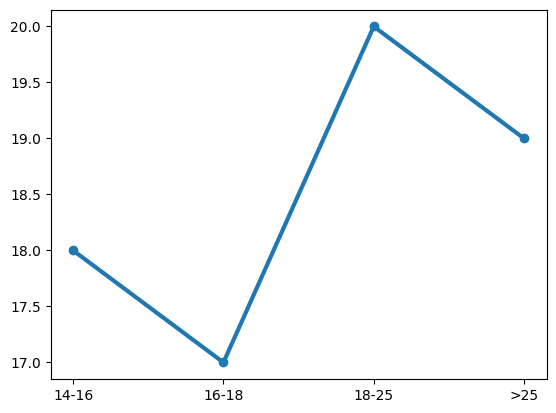

In [604]:
# Track the popularity of travelling through the age ranges

age_ranges = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Split the activities into a list
age_ranges = age_ranges.apply(lambda x: x.split(';'))

# Remove the <14 age range because there is too little data
age_ranges = age_ranges.drop('<14')

# Count the number of times "Travelling, visiting cities and places of interest" is mentioned
beach_per_age = age_ranges.apply(lambda x: x.count('travelling, visiting cities and places of interest'))
# Count the total number of activities for each age range
total_per_age = age_ranges.apply(lambda x: len(x))

# Calculate the percentage of travelling
percentages = [int(trav / total * 100) for trav, total in zip(beach_per_age, total_per_age)]    

# Plot the popularity of travelling through the age ranges using a curved line graph with filled area
import matplotlib.pyplot as plt

plt.plot(age_ranges.index, percentages, linestyle='solid', linewidth=3, marker='o')
plt.show()

# People start travelling more as they get older.
# The boom in travelling happens between 18 and 25 years old
# People stop travelling as much after 25 probably because of work


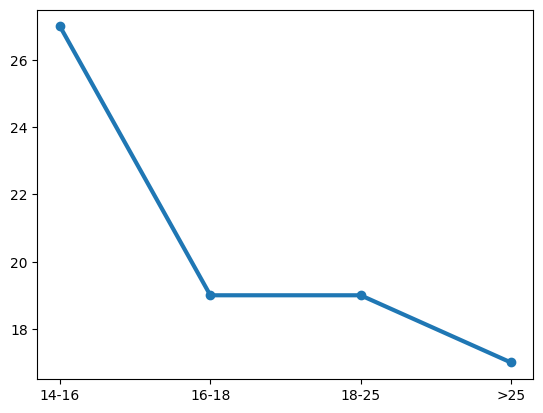

In [605]:
# Calculate the popularity of going to the beach through the age ranges

age_ranges = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Split the activities into a list
age_ranges = age_ranges.apply(lambda x: x.split(';'))

# Remove the <14 age range because there is too little data
age_ranges = age_ranges.drop('<14')

# Count the number of times "Travelling, visiting cities and places of interest" is mentioned
beach_per_age = age_ranges.apply(lambda x: x.count('going to the beach'))
# Count the total number of activities for each age range
total_per_age = age_ranges.apply(lambda x: len(x))

# Calculate the percentage of travelling
percentages = [int(beach / total * 100) for beach, total in zip(beach_per_age, total_per_age)]    

# Plot the popularity of travelling through the age ranges using a curved line graph with filled area
import matplotlib.pyplot as plt

plt.plot(age_ranges.index, percentages, linestyle='solid', linewidth=3, marker='o')
plt.show()

# Going to the beach becomes less popular as people get older in favor of other activities

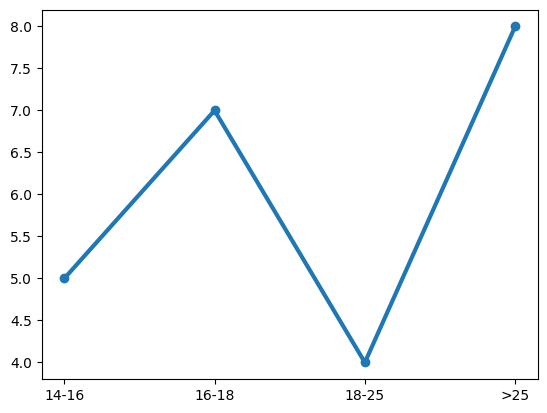

In [606]:
# Plot the popularity of attending events through the age ranges

age_ranges = df.groupby('age')['activities'].apply(lambda x: ';'.join(x))

# Split the activities into a list
age_ranges = age_ranges.apply(lambda x: x.split(';'))

# Remove the <14 age range because there is too little data
age_ranges = age_ranges.drop('<14')

# Count the number of times "attending concerts or live events (e.g. football match)" is mentioned
events_per_age = age_ranges.apply(lambda x: x.count('attending concerts or live events (e.g. football match)'))
# Count the total number of activities for each age range
total_per_age = age_ranges.apply(lambda x: len(x))

# Calculate the percentage of attending events
percentages = [int(events / total * 100) for events, total in zip(events_per_age, total_per_age)]

# Plot the popularity of attending events through the age ranges using a curved line graph with filled area
import matplotlib.pyplot as plt

plt.plot(age_ranges.index, percentages, linestyle='solid', linewidth=3, marker='o')
plt.show()



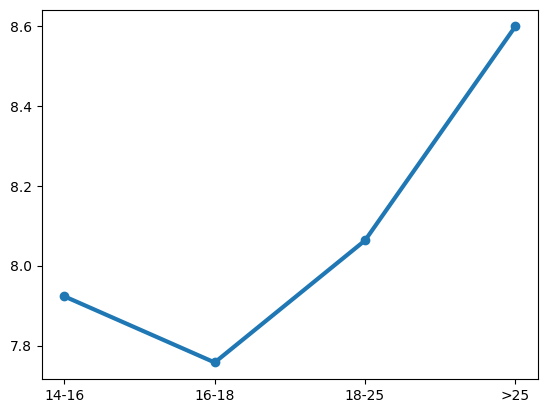

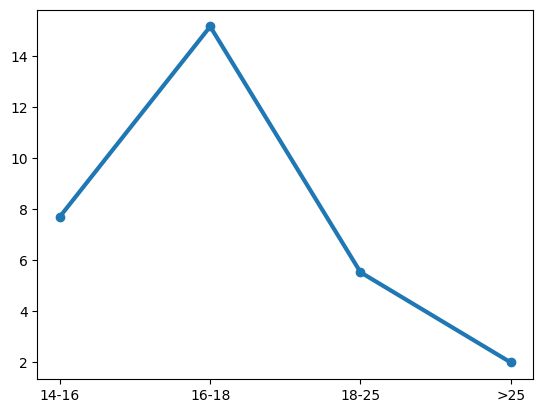

In [607]:
# Calculate the average enjoyment through the age ranges

enjoyment_per_age = df.groupby('age')['enjoyment'].apply(lambda x: x.mean())
enjoyment_per_age

# Remove the <14 age range because there is too little data
enjoyment_per_age = enjoyment_per_age.drop('<14')

# Plot the average enjoyment through the age ranges
import matplotlib.pyplot as plt

plt.plot(enjoyment_per_age.index, enjoyment_per_age.values, linestyle='solid', linewidth=3, marker='o')
plt.show()

# Calculate which age range has the highest percentage of people who didn't enjoy their vacation
enjoyment_per_age = df.groupby('age')['enjoyment']

# Calculate the percentage of people who didn't enjoy their vacation (enjoyment < 6)
percentages = enjoyment_per_age.apply(lambda x: len(x[x < 6]) / len(x) * 100)

# Remove the <14 age range because there is too little data
percentages = percentages.drop('<14')

# Plot the percentage of people who didn't enjoy their vacation through the age ranges

plt.plot(percentages.index, percentages.values, linestyle='solid', linewidth=3, marker='o')
plt.show()



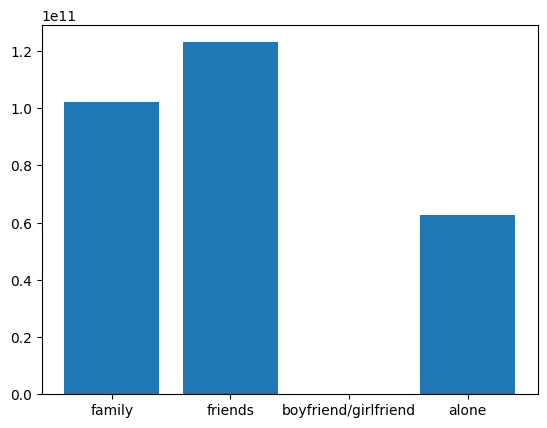

In [608]:
# Calculate enjoyment per company

# Split the companies into a list
companies = df['company'].apply(lambda x: x.split(';'))

unique_activities = ['family', 'friends', 'boyfriend/girlfriend', 'alone']
enjoyment = [0, 0, 0, 0]
counts = [0, 0, 0, 0]
for i, company_type in enumerate(unique_activities):
    # Count the number of times each company type is mentioned
    company_count = companies.apply(lambda x: x.count(company_type))

    # Get the enjoyment if the company type is mentioned
    enjoyment[i] = df[company_count > 0]['enjoyment'].mean()

enjoyment

# Plot the average enjoyment per company type
import matplotlib.pyplot as plt

# Emphasize the difference between the company types
enjoyment = [enjoy ** 12 for enjoy in enjoyment]

plt.bar(unique_activities, enjoyment)
plt.show()
    
    

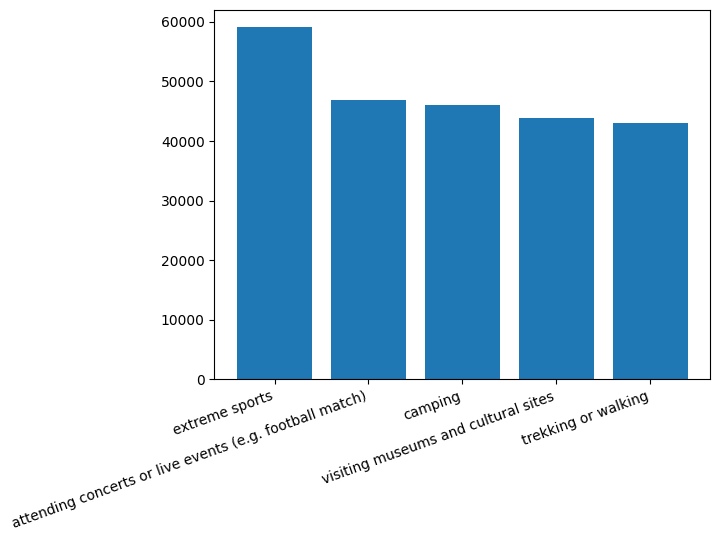

{'extreme sports': 9.0,
 'attending concerts or live events (e.g. football match)': 8.590909090909092,
 'camping': 8.560975609756097,
 'visiting museums and cultural sites': 8.481171548117155,
 'trekking or walking': 8.447368421052632,
 'travelling, visiting cities and places of interest': 8.406130268199234,
 'going to the beach': 8.307692307692308,
 'cruise': 8.173913043478262,
 'staying at home': 7.894736842105263,
 'relaxing': 7.833333333333333,
 'working': 7.64,
 'sailing': 7.0,
 'nan': 0.0,
 'n/a (only been on vacation in my childhood)': 0.0}

In [609]:
# Caluclate the average enjoyment for each activity

# Split the activities into a list
activities = df['activities'].apply(lambda x: x.split(';'))


# Get all the unique activities
unique_activities = set()
for activity in activities:
    unique_activities.update(activity)
unique_activities = list(unique_activities)

enjoyment = [0] * len(unique_activities)

for i, activity_type in enumerate(unique_activities):
    # Count the number of times each activity type is mentioned
    activity_count = activities.apply(lambda x: x.count(activity_type))

    # Get the enjoyment if the company type is mentioned
    enjoyment[i] = df[activity_count > 0]['enjoyment'].mean()

enjoyment

# Plot the average enjoyment per actiivty type
import matplotlib.pyplot as plt

# Sort the activities by their enjoyment
enjoyment, unique_activities = zip(*reversed(sorted(zip(enjoyment, unique_activities))))

# Remove 'shooting'
enjoyment, unique_activities = zip(*[(enjoy, activity) for enjoy, activity in zip(enjoyment, unique_activities) if activity != 'shooting'])

# Keep only the top 5 activities
enjoyment_top_5 = enjoyment[:5]
unique_activities_top_5 = unique_activities[:5]

# Emphasize the difference between the activity types
enjoyment_top_5 = [enjoy ** 5 for enjoy in enjoyment_top_5]

plt.bar(unique_activities_top_5, enjoyment_top_5)
plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
plt.show()


dict(zip(unique_activities, enjoyment))



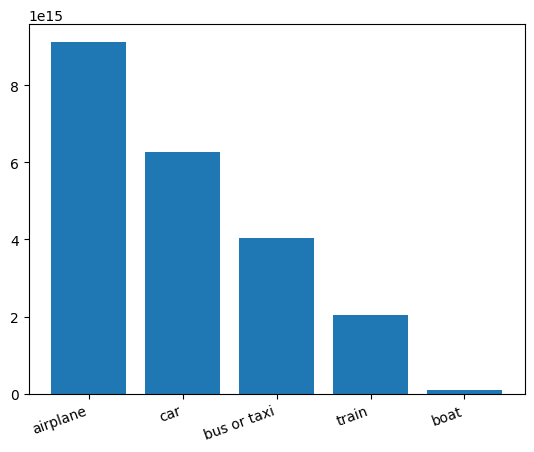

{'airplane': 1556.0,
 'car': 1443.5378787878788,
 'bus or taxi': 1321.2941176470588,
 'train': 1154.0824175824175,
 'boat': 612.5,
 'bycicle': 200.0,
 'car and ship': 0.0}

In [610]:
# Calculate average cost for transport

# Split the transports into a list
transports = df['transport'].apply(lambda x: x.split(';'))

# Get all the unique transports
unique_transports = set()
for transport in transports:
    unique_transports.update(transport)
unique_transports = list(unique_transports)

cost = [0] * len(unique_transports)

for i, transport_type in enumerate(unique_transports):
    # Count the number of times each transport type is mentioned
    transport_count = transports.apply(lambda x: x.count(transport_type))

    # Get the cost if the transport type is mentioned
    cost[i] = df[transport_count > 0]['cost'].mean()


# Plot the average cost per transport type
import matplotlib.pyplot as plt

# Sort the activities by their cost
cost, unique_transports = zip(*reversed(sorted(zip(cost, unique_transports))))

# Keep only the top 5 activities
cost_top_5 = cost[:5]
unique_activities_top_5 = unique_transports[:5]

# Emphasize the difference between the activity types
cost_top_5 = [c ** 5 for c in cost_top_5]

plt.bar(unique_activities_top_5, cost_top_5)
plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
plt.show()


dict(zip(unique_transports, cost))


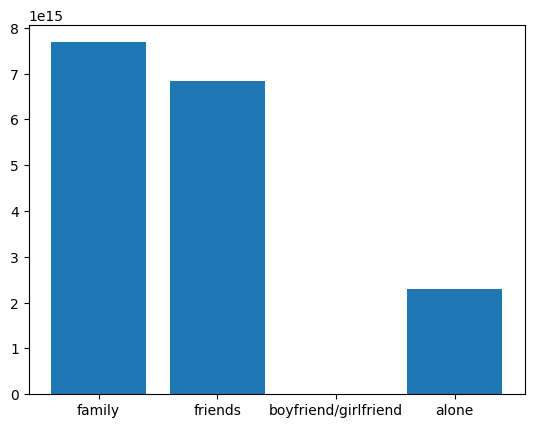

{'family': 1503.5157894736842,
 'friends': 1469.2170542635658,
 'boyfriend/girlfriend': nan,
 'alone': 1179.9545454545455}

In [611]:
# Calculate average cost per company

# Split the companies into a list
companies = df['company'].apply(lambda x: x.split(';'))

unique_companies = ['family', 'friends', 'boyfriend/girlfriend', 'alone']
cost = [0, 0, 0, 0]
counts = [0, 0, 0, 0]
for i, company_type in enumerate(unique_companies):
    # Count the number of times each company type is mentioned
    company_count = companies.apply(lambda x: x.count(company_type))

    # Get the cost if the company type is mentioned
    cost[i] = df[company_count > 0]['cost'].mean()


# Plot the average cost per company type
import matplotlib.pyplot as plt

# Emphasize the difference between the company types
cost_emphasized = [c ** 5 for c in cost]

plt.bar(unique_companies, cost_emphasized)
plt.show()

dict(zip(unique_companies, cost))


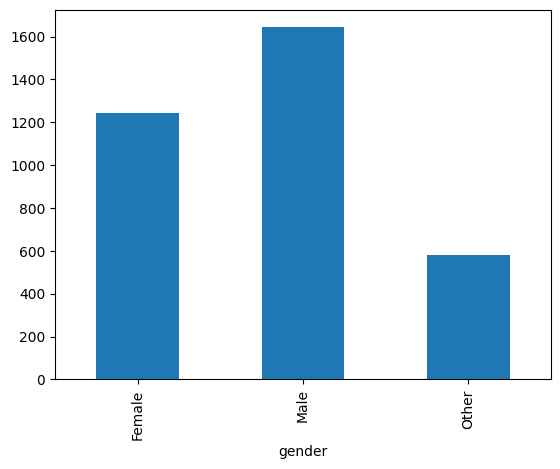

In [612]:
# Calculate average cost per gender

genders = df.groupby('gender')['cost'].apply(lambda x: x.mean())

# Plot the average using a bar chart
import matplotlib.pyplot as plt

genders.plot.bar()
plt.show()


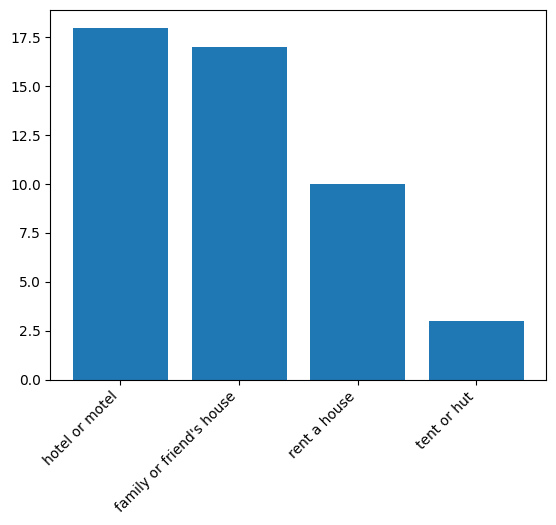

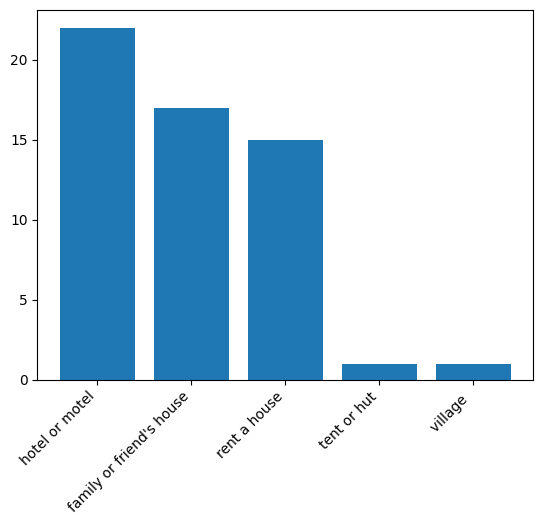

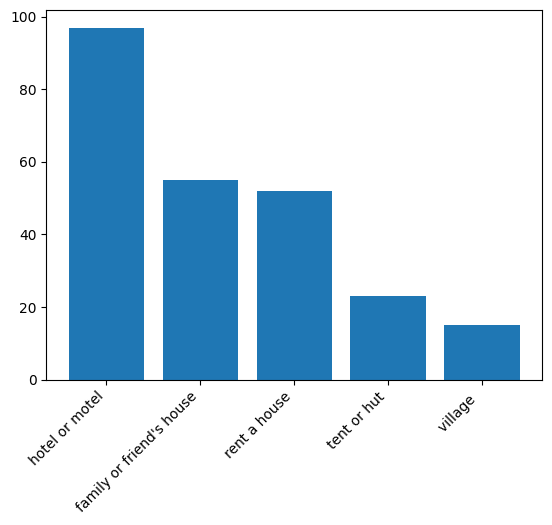

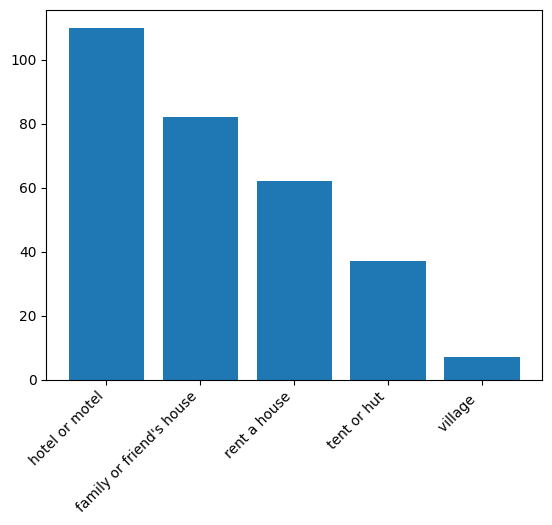

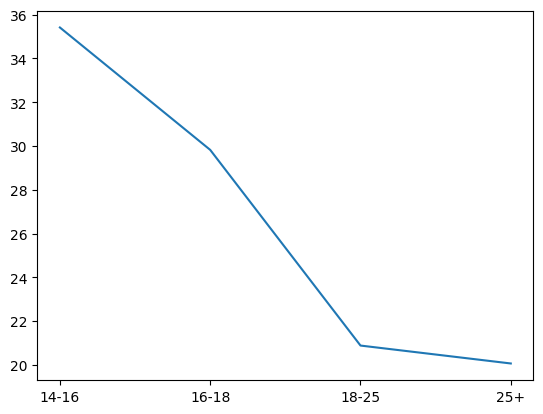

{'14-16': 35.41666666666667, '16-18': 29.82456140350877, '18-25': 20.883534136546185, '25+': 20.06472491909385}


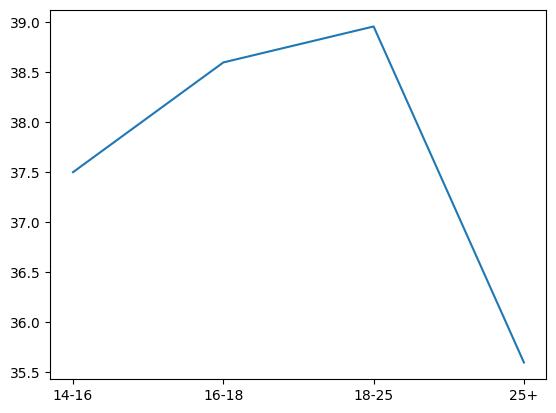

{'14-16': 37.5, '16-18': 38.59649122807017, '18-25': 38.95582329317269, '25+': 35.59870550161812}


,hotel or motel,family or friend's house,rent a house,tent or hut,village,air bnb,camper,n/a i live near vegas so no sleeping there,airbnb/vrbo,boat,...,airb&b,cottage,condo,hostel,cabin,sommarstuga,vehicle,nan,cruise ship,holiday inn
age,,,,,,,,,,,,,,,,,,,,,
14-16,18.0,17.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16-18,22.0,17.0,15.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18-25,97.0,52.0,55.0,23.0,0.0,0.0,15.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
>25,110.0,62.0,82.0,37.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0


In [613]:
# Track accomodation popularity through the age ranges

# Split the accomodation into a list
accomodation = df.groupby('age')['accommodation'].apply(lambda x: x.str.split(';').sum())

# Remove the <14 age range because there's too little data
accomodation = accomodation.drop('<14')

# for each age range count the times each accomodation type is mentioned
accomodation = accomodation.apply(lambda x: pd.Series(x).value_counts())

# Fill the missing values with 0
accomodation = accomodation.fillna(0)

# Split into age ranges and remove the accomodation where there's no data
accomodation_14_16 = sorted(accomodation.iloc[0], reverse=True)
labels_14_16 = accomodation.iloc[0].index
accomodation_14_16, labels_14_16 = zip(*[(accomodation, label) for accomodation, label in zip(accomodation_14_16, labels_14_16) if accomodation > 0])

accomodation_16_18 = sorted(accomodation.iloc[1], reverse=True)
labels_16_18 = accomodation.iloc[1].index
accomodation_16_18, labels_16_18 = zip(*[(accomodation, label) for accomodation, label in zip(accomodation_16_18, labels_16_18) if accomodation > 0])

accomodation_18_25 = sorted(accomodation.iloc[2], reverse=True)
labels_18_25 = accomodation.iloc[2].index
accomodation_18_25, labels_18_25 = zip(*[(accomodation, label) for accomodation, label in zip(accomodation_18_25, labels_18_25) if accomodation > 0])

accomodation_25_ = sorted(accomodation.iloc[3], reverse=True)
labels_25_ = accomodation.iloc[3].index
accomodation_25_, labels_25_ = zip(*[(accomodation, label) for accomodation, label in zip(accomodation_25_, labels_25_) if accomodation > 0])

# Plot the accomodation popularity for each age range using a bar chart
import matplotlib.pyplot as plt

plt.bar(labels_14_16[:5], accomodation_14_16[:5])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(labels_16_18[:5], accomodation_16_18[:5])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(labels_18_25[:5], accomodation_18_25[:5])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(labels_25_[:5], accomodation_25_[:5])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


# Track the popularity of 'family or friend's house' through the age ranges

# Caluclate the number of times 'family or friend's house' is mentioned through each age range
age_ranges = ['14-16', '16-18', '18-25', '25+']
percentages = [0, 0, 0, 0]
for i, age_range in enumerate(age_ranges):
    # Get the number of times 'family or friend's house' is mentioned
    family_friends_house = accomodation.iloc[i]['family or friend\'s house']

    # Get the total number of accomodation types mentioned
    total = accomodation.iloc[i].sum()

    # Calculate the percentage
    percentages[i] = family_friends_house / total * 100

# Plot the percentage using a line chart
import matplotlib.pyplot as plt

plt.plot(age_ranges, percentages)
plt.show()

print(dict(zip(age_ranges, percentages)))

# Track the popularity of 'hotel or motel' through the age ranges

# Caluclate the number of times 'hotel or motel' is mentioned through each age range
age_ranges = ['14-16', '16-18', '18-25', '25+']
percentages = [0, 0, 0, 0]
for i, age_range in enumerate(age_ranges):
    # Get the number of times 'hotel or motel' is mentioned
    hotel_motel = accomodation.iloc[i]['hotel or motel']

    # Get the total number of accomodation types mentioned
    total = accomodation.iloc[i].sum()

    # Calculate the percentage
    percentages[i] = hotel_motel / total * 100

# Plot the percentage using a line chart

plt.plot(age_ranges, percentages)
plt.show()

print(dict(zip(age_ranges, percentages)))

accomodation


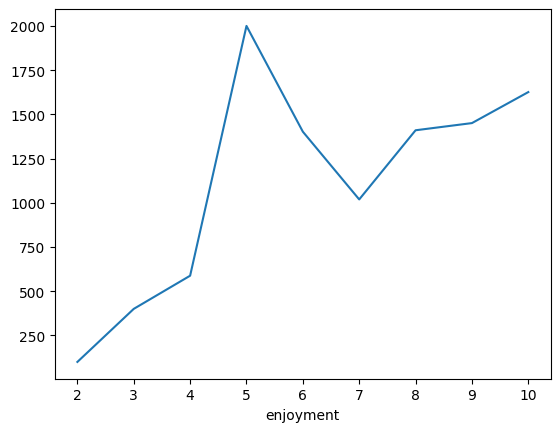

enjoyment
2      100.000000
3      400.000000
4      587.500000
5     2000.000000
6     1401.900000
7     1018.843750
8     1409.933333
9     1450.524590
10    1625.880000
Name: cost, dtype: float64

In [614]:
# Correlate cost and enjoyment without counting NaN values

# Get the cost and enjoyment columns
cost_enjoyment = df[['cost', 'enjoyment']]
cost_enjoyment = cost_enjoyment.dropna()

costs = cost_enjoyment.groupby('enjoyment')['cost'].apply(lambda x: x.mean())

# Plot a line chart
import matplotlib.pyplot as plt

costs.plot.line()
plt.show()

costs


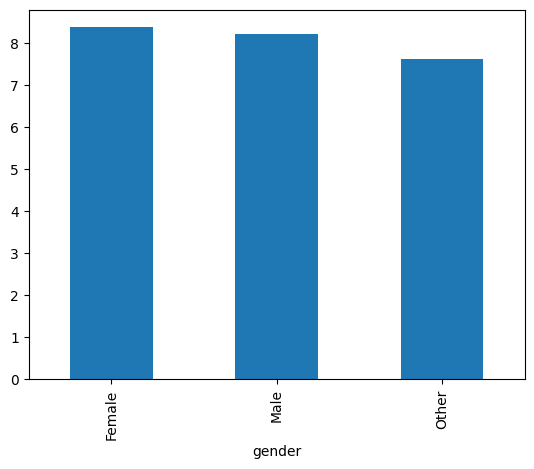

gender
Female    8.378205
Male      8.227545
Other     7.625000
Name: enjoyment, dtype: float64

In [615]:
# Calculate enjoyment per gender

enjoyment = df.groupby('gender')['enjoyment'].apply(lambda x: x.mean())

# Plot a bar chart
import matplotlib.pyplot as plt

enjoyment.plot.bar()
plt.show()

enjoyment

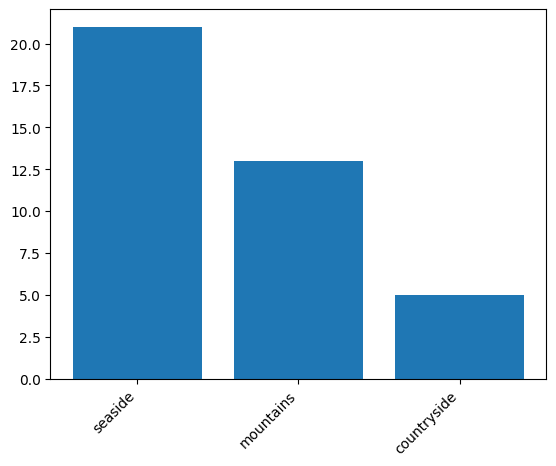

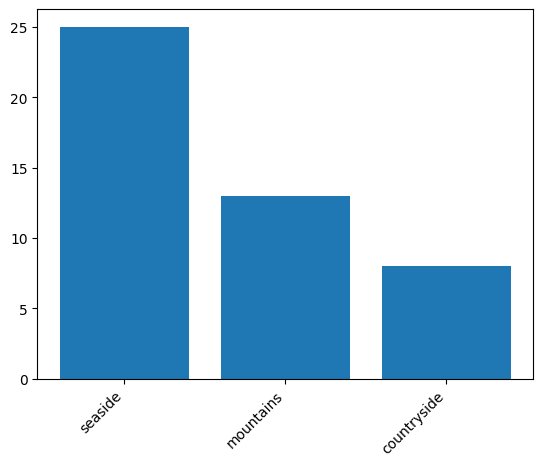

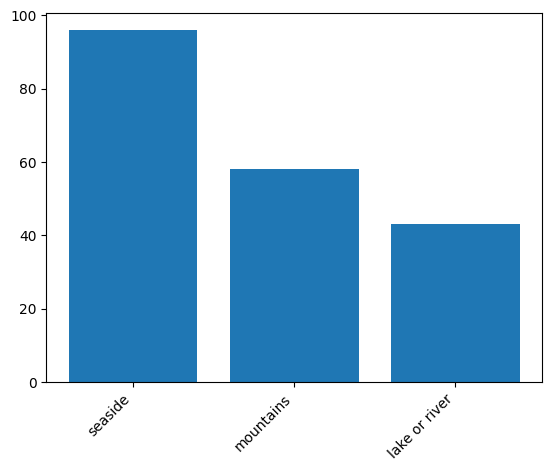

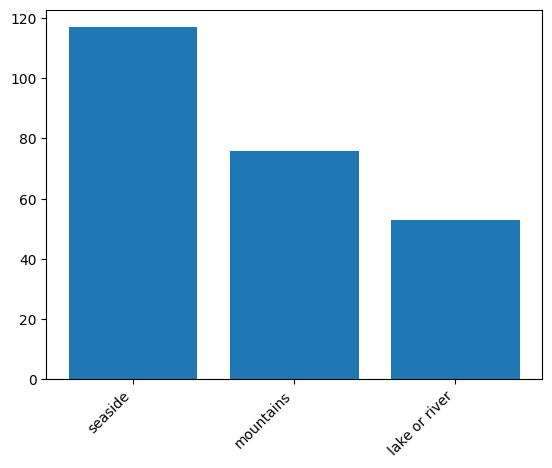

,seaside,mountains,countryside,lake or river,city,shooting range,visiting family,at my family's house in taiwan,urban,forest,desert or national park,"seaside in the past (childhood), n/a now",inland,always in the same state i live,cultural and historical places as well,wooded parks,i don't really do holidays,"i've been unabole to work for a long time and while i could afford to travel, my anxiety usually prevents me from doing more than the occasional day trip"
age,,,,,,,,,,,,,,,,,,
14-16,21.0,13.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16-18,25.0,13.0,8.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18-25,96.0,58.0,38.0,43.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
>25,117.0,76.0,44.0,53.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [616]:
# Get the most popular targets for each age range
    
targets = df.groupby('age')['target'].apply(lambda x: ';'.join(x))

# Drop the <14 age range because there is too little data
targets = targets.drop('<14')

# Split the targets into a list
targets = targets.apply(lambda x: x.split(';'))

# Count the number of times each target appears
targets = targets.apply(lambda x: pd.Series(x).value_counts())

# Substitue NaN with 0
targets = targets.fillna(0)

# Sum the number of times each target appears for each age range
targets = targets.groupby(targets.index).sum()

POWER_EMPHASIS = 1

# Split the targets into age ranges and sort them from highest to lowest and keep only the top 3
targets_14_16 = targets.loc['14-16'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
targets_16_18 = targets.loc['16-18'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
targets_18_25 = targets.loc['18-25'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)
targets_25 = targets.loc['>25'].sort_values(ascending=False).head(3).apply(lambda x: x ** POWER_EMPHASIS)

# Plot the most popular targets for each age range
import matplotlib.pyplot as plt

plt.bar(targets_14_16.index, targets_14_16.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(targets_16_18.index, targets_16_18.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(targets_18_25.index, targets_18_25.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

plt.bar(targets_25.index, targets_25.values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

targets
